[Autoencoder](https://alanbertl.com/autoencoder-with-fast-ai/)

[Hook](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson6-pets-more.ipynb)

[Fast.ai](https://nbviewer.jupyter.org/github/fastai/course-v3/blob/master/nbs/dl1/lesson5-sgd-mnist.ipynb)

# Import modules

In [1]:
import pandas as pd
import numpy as np
from scipy.special import erfinv
import matplotlib.pyplot as plt
import torch
from torch.utils.data import *
from torch.optim import *
from fastai.tabular import *
import torch.utils.data as Data
from fastai.basics import *
from fastai.callbacks.hooks import *
from tqdm import tqdm_notebook as tqdm
import gc

%matplotlib inline

# Import dataset and concatenate it

In [2]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")

In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [4]:
train_test = pd.concat([train, test]).reset_index()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [5]:
train_test = train_test.sample(frac=0.5)

In [6]:
train_test.reset_index(inplace=True)

In [7]:
train_test.head()

,level_0,index,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,...,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99
0,233627,33627,test_33627,NaN,10.8112,-7.6100,-6.6748,3.9068,6.0816,31.2732,1.2945,10.8455,3.4793,8.4496,13.1924,14.2420,20.3643,-6.6658,2.4439,6.3083,0.8340,11.1618,3.3063,2.9962,0.0695,12.9839,-2.5986,7.7080,14.1861,38.0511,15.0982,-8.8987,5.0116,1.7077,12.3887,12.7664,5.0881,0.2320,16.2852,1.5370,...,0.4880,7.1396,2.5891,6.5477,17.8987,5.0154,-1.9508,13.3348,5.3347,1.0013,-5.6585,16.0583,-13.3020,15.0864,8.7267,15.5583,5.0700,12.4669,-3.4374,3.1862,15.3395,-2.7592,10.0103,-7.3565,16.5358,-0.6244,10.6827,8.8599,0.4949,7.5898,-33.7302,7.0665,21.9870,10.9232,9.0556,0.6050,11.1400,36.1836,-0.0749,-0.2650
1,305907,105907,test_105907,NaN,13.7586,-6.7236,-1.6950,-14.1480,11.9356,14.5691,1.5734,12.1880,3.5629,7.8814,16.3702,14.4507,27.0531,-0.3992,-0.4511,7.3309,2.6264,11.4391,1.9326,0.3944,1.8425,8.0017,3.0880,1.9218,13.6610,28.0710,11.0258,5.2662,-7.4634,4.2203,12.2053,12.4070,-4.2940,-6.7609,11.7560,9.7874,...,4.1354,6.0284,-3.1563,7.8351,19.3715,5.0237,-12.3332,15.0452,27.8340,1.2802,-0.6664,27.8581,25.1779,16.8820,13.1756,18.6616,3.0265,14.8001,3.5641,-5.3676,20.6227,2.5529,7.9930,-10.3111,14.8155,0.2616,13.5927,12.8546,3.4500,9.0191,-19.2646,6.8559,13.1587,11.5103,10.7803,0.2632,13.7878,1.8401,2.0747,0.1981
2,64423,64423,train_64423,0.0,11.7224,1.9739,1.8380,7.1313,12.4894,12.7425,1.8013,13.0598,3.1128,7.9973,27.2475,13.9954,16.8596,-2.9033,4.6355,4.6753,3.8077,12.7237,3.4274,-3.1244,2.2666,3.7203,0.5099,10.6441,14.2362,0.3941,11.7620,3.4909,8.0041,3.0567,12.5681,12.8974,3.2269,-3.1889,15.0085,6.2773,...,-0.9296,6.0947,0.7048,4.9362,13.7451,5.0301,-2.2731,19.1073,30.8873,0.6916,3.7441,23.5553,7.9436,17.0112,12.2779,23.7978,6.2244,14.2616,-0.8083,5.3810,13.6786,8.7943,-20.5082,11.4123,18.5311,-0.7068,14.8165,7.0824,1.9529,6.6977,4.7273,7.1155,8.8702,11.4947,12.7101,-0.0064,13.6891,14.3938,1.8081,-2.3887
3,12170,12170,train_12170,1.0,12.3603,-3.8214,-2.7194,11.5081,8.2412,13.4107,1.4295,11.2270,4.7086,11.7429,8.2619,13.9758,21.7103,-2.0055,-0.5495,7.5111,5.6527,9.4809,2.3605,1.6631,1.6436,3.7387,-28.3029,1.1801,13.6243,10.2168,11.4473,3.5196,-5.5329,9.1199,12.1279,14.2829,4.7512,1.2968,11.8280,17.9903,...,-1.0658,5.5789,2.5348,5.3500,13.9453,5.0216,-1.4439,17.7382,35.7896,0.2966,6.4312,25.6282,33.5082,15.1616,1.1070,21.5359,5.6795,13.3378,4.5694,-3.6073,12.8009,6.2968,8.0802,1.1008,16.3218,-5.2591,18.8184,11.1315,10.2631,8.9006,1.7851,7.0529,18.3219,10.2359,13.2960,-0.7723,4.0746,-3.1544,1.5276,-1.1366
4,372364,172364,test_172364,NaN,9.7302,0.0345,5.3979,-0.2953,10.6693,33.9462,1.3258,14.8231,3.2655,9.8283,11.0682,14.1722,26.4835,-6.7726,7.5556,5.9318,3.8232,5.5592,3.6297,8.3469,1.9958,11.3346,-14.1577,7.2374,14.0326,50.8170,11.3078,1.3961,7.0140,5.0464,12.1201,13.7902,-2.5144,2.4268,11.6219,3.5078,...,0.7245,6.8555,2.5195,6.5741,8.1901,5.0159,-7.1261,18.8396,41.0720,0.5093,3.5935,15.4229,33.5672,16.4257,9.4783,14.1925,5.2563,13.3541,2.4216,4.5778,15.4845,-9.9528,0.0283,-3.8608,19.1746,9.3896,14.8693,7.2546,1.5359,6.6212,-7.5589,7.2184,3.7604,10.0066,14.5980,0.6193,12.4168,21.0301,2.4192,2.9131


In [8]:
def preprocess(data):
    usecols = [c for c in data.columns]
    data = data.loc[:,usecols]
    #cat_features = [c for c in data.columns if 'cat' in c]
    #add_df = data[cat_features]
    #data = pd.get_dummies(data, columns=cat_features)
    #data = pd.concat([data, add_df], axis= 1).drop('index', 1)
    data = data.drop(['index', 'level_0'], 1)
    return data

In [9]:
data = preprocess(train_test)

In [10]:
data.head()

,ID_code,target,var_0,var_1,var_10,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_11,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_12,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_13,var_130,var_131,...,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_7,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_8,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_9,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99
0,test_33627,NaN,10.8112,-7.6100,-6.6748,3.9068,6.0816,31.2732,1.2945,10.8455,3.4793,8.4496,13.1924,14.2420,20.3643,-6.6658,2.4439,6.3083,0.8340,11.1618,3.3063,2.9962,0.0695,12.9839,-2.5986,7.7080,14.1861,38.0511,15.0982,-8.8987,5.0116,1.7077,12.3887,12.7664,5.0881,0.2320,16.2852,1.5370,13.0375,0.2714,...,0.4880,7.1396,2.5891,6.5477,17.8987,5.0154,-1.9508,13.3348,5.3347,1.0013,-5.6585,16.0583,-13.3020,15.0864,8.7267,15.5583,5.0700,12.4669,-3.4374,3.1862,15.3395,-2.7592,10.0103,-7.3565,16.5358,-0.6244,10.6827,8.8599,0.4949,7.5898,-33.7302,7.0665,21.9870,10.9232,9.0556,0.6050,11.1400,36.1836,-0.0749,-0.2650
1,test_105907,NaN,13.7586,-6.7236,-1.6950,-14.1480,11.9356,14.5691,1.5734,12.1880,3.5629,7.8814,16.3702,14.4507,27.0531,-0.3992,-0.4511,7.3309,2.6264,11.4391,1.9326,0.3944,1.8425,8.0017,3.0880,1.9218,13.6610,28.0710,11.0258,5.2662,-7.4634,4.2203,12.2053,12.4070,-4.2940,-6.7609,11.7560,9.7874,12.2059,0.2490,...,4.1354,6.0284,-3.1563,7.8351,19.3715,5.0237,-12.3332,15.0452,27.8340,1.2802,-0.6664,27.8581,25.1779,16.8820,13.1756,18.6616,3.0265,14.8001,3.5641,-5.3676,20.6227,2.5529,7.9930,-10.3111,14.8155,0.2616,13.5927,12.8546,3.4500,9.0191,-19.2646,6.8559,13.1587,11.5103,10.7803,0.2632,13.7878,1.8401,2.0747,0.1981
2,train_64423,0.0,11.7224,1.9739,1.8380,7.1313,12.4894,12.7425,1.8013,13.0598,3.1128,7.9973,27.2475,13.9954,16.8596,-2.9033,4.6355,4.6753,3.8077,12.7237,3.4274,-3.1244,2.2666,3.7203,0.5099,10.6441,14.2362,0.3941,11.7620,3.4909,8.0041,3.0567,12.5681,12.8974,3.2269,-3.1889,15.0085,6.2773,12.2141,0.1185,...,-0.9296,6.0947,0.7048,4.9362,13.7451,5.0301,-2.2731,19.1073,30.8873,0.6916,3.7441,23.5553,7.9436,17.0112,12.2779,23.7978,6.2244,14.2616,-0.8083,5.3810,13.6786,8.7943,-20.5082,11.4123,18.5311,-0.7068,14.8165,7.0824,1.9529,6.6977,4.7273,7.1155,8.8702,11.4947,12.7101,-0.0064,13.6891,14.3938,1.8081,-2.3887
3,train_12170,1.0,12.3603,-3.8214,-2.7194,11.5081,8.2412,13.4107,1.4295,11.2270,4.7086,11.7429,8.2619,13.9758,21.7103,-2.0055,-0.5495,7.5111,5.6527,9.4809,2.3605,1.6631,1.6436,3.7387,-28.3029,1.1801,13.6243,10.2168,11.4473,3.5196,-5.5329,9.1199,12.1279,14.2829,4.7512,1.2968,11.8280,17.9903,12.2836,1.4757,...,-1.0658,5.5789,2.5348,5.3500,13.9453,5.0216,-1.4439,17.7382,35.7896,0.2966,6.4312,25.6282,33.5082,15.1616,1.1070,21.5359,5.6795,13.3378,4.5694,-3.6073,12.8009,6.2968,8.0802,1.1008,16.3218,-5.2591,18.8184,11.1315,10.2631,8.9006,1.7851,7.0529,18.3219,10.2359,13.2960,-0.7723,4.0746,-3.1544,1.5276,-1.1366
4,test_172364,NaN,9.7302,0.0345,5.3979,-0.2953,10.6693,33.9462,1.3258,14.8231,3.2655,9.8283,11.0682,14.1722,26.4835,-6.7726,7.5556,5.9318,3.8232,5.5592,3.6297,8.3469,1.9958,11.3346,-14.1577,7.2374,14.0326,50.8170,11.3078,1.3961,7.0140,5.0464,12.1201,13.7902,-2.5144,2.4268,11.6219,3.5078,12.4191,0.3794,...,0.7245,6.8555,2.5195,6.5741,8.1901,5.0159,-7.1261,18.8396,41.0720,0.5093,3.5935,15.4229,33.5672,16.4257,9.4783,14.1925,5.2563,13.3541,2.4216,4.5778,15.4845,-9.9528,0.0283,-3.8608,19.1746,9.3896,14.8693,7.2546,1.5359,6.6212,-7.5589,7.2184,3.7604,10.0066,14.5980,0.6193,12.4168,21.0301,2.4192,2.9131


# Rank Guass

In [11]:
def to_gauss(x): return np.sqrt(2)*erfinv(x)  #from scipy

def normalize(data, exclude=None):
    # if not binary, normalize it
    norm_cols = [n for n, c in data.drop(exclude, 1).items() if len(np.unique(c)) > 2]
    n = data.shape[0]
    for col in norm_cols:
        sorted_idx = data[col].sort_values().index.tolist()# list of sorted index
        uniform = np.linspace(start=-0.99, stop=0.99, num=n) # linsapce
        normal = to_gauss(uniform) # apply gauss to linspace
        normalized_col = pd.Series(index=sorted_idx, data=normal) # sorted idx and normalized space
        data[col] = normalized_col # column receives its corresponding rank
    return data

In [12]:
norm_data = normalize(data, exclude=['ID_code', 'target'])

# DAE

In [13]:
dropcols= ['ID_code', 'target']
#X = np.array(norm_data.drop(dropcols, 1))
save = norm_data.loc[:, dropcols+['var_0']]
X = norm_data.drop(dropcols, 1)

In [14]:
X.shape

(200000, 200)

In [15]:
del norm_data
del train
del test
del train_test
del data

In [16]:
def inputSwapNoise(arr, p):
    ### Takes a numpy array and swaps a row of each 
    ### feature with another value from the same column with probability p
    
    n, m = arr.shape
    idx = range(n)
    swap_n = round(n*p)
    for i in range(m):
        col_vals = np.random.permutation(arr[:, i]) # change the order of the row
        swap_idx = np.random.choice(idx, size= swap_n) # choose row
        arr[swap_idx, i] = np.random.choice(col_vals, size = swap_n) # n*p row and change it 
    return arr

In [17]:
class BatchSwapNoise(nn.Module):
    """Swap Noise module"""

    def __init__(self, p):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.rand(x.size()) > (1 - self.p)
            idx = torch.add(torch.arange(x.nelement()),
                            (torch.floor(torch.rand(x.size()) * x.size(0)).type(torch.LongTensor) *
                             (mask.type(torch.LongTensor) * x.size(1))).view(-1))
            idx[idx>=x.nelement()] = idx[idx>=x.nelement()]-x.nelement()
            return x.view(-1)[idx].view(x.size())
        else:
            return x

In [18]:
class ArraysItemList(FloatList):
    def __init__(self, items:Iterator, log:bool=False, **kwargs):
        if isinstance(items, ItemList):
            items = items.items
        super(FloatList,self).__init__(items,**kwargs)
    
    def get(self,i):
        return Tensor(super(FloatList,self).get(i).astype('float32'))

In [19]:
x_il = ArraysItemList(X)
x_ils = x_il.split_by_rand_pct()
lls = x_ils.label_from_lists(x_ils.train, x_ils.valid)
data = lls.databunch(bs=32)

In [20]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([32, 200]), torch.Size([32, 200]))

In [21]:
data.train_ds

LabelList (160000 items)
x: ArraysItemList
tensor([ 8.8067e-02, -1.4463e+00, -1.2032e+00,  1.0846e+00, -1.4622e+00,
         9.6522e-01, -1.4401e+00, -3.1038e-01, -8.5929e-01, -7.8144e-02,
        -5.3536e-01,  6.5927e-02,  3.7715e-01, -5.3033e-01, -7.6415e-01,
        -2.8201e-02, -1.4752e+00,  5.7740e-01,  1.9920e-01,  2.5962e-01,
        -1.3197e+00, -2.0165e-01,  2.7841e-01,  1.0635e+00,  7.8833e-01,
         1.0521e+00,  2.2619e+00, -1.9018e+00, -3.0001e-01, -9.0049e-01,
        -2.5719e-01, -4.4939e-01,  1.3004e+00,  3.4961e-01,  1.9612e-01,
        -1.4530e+00,  8.6824e-01, -5.4235e-01,  3.4078e-01, -1.5894e+00,
        -2.9107e-02, -1.1561e+00,  3.2879e-01,  9.0385e-01,  1.2418e-01,
         1.1585e+00, -1.7167e+00,  7.9043e-01, -2.3075e+00,  1.3884e-01,
        -1.6162e+00, -8.0565e-01,  1.7978e+00, -8.5834e-01,  2.0841e-02,
         1.6502e+00, -1.8221e+00,  2.8555e-01, -1.7456e+00,  8.2358e-01,
        -6.7043e-01,  2.8897e-01,  4.3994e-02, -2.0694e+00, -3.0840e-01,
        

In [22]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise = BatchSwapNoise(0.15)
        self.encoder = nn.Sequential(
            nn.Linear(200, 300),
            nn.Linear(300, 300),
            nn.Linear(300, 300)
        )
        self.decoder = nn.Sequential(
            nn.Linear(300, 300),
            nn.Linear(300, 200)
        )

    def forward(self, xb): 
        encoder = self.encoder(self.noise(xb))
        decoder = self.decoder(encoder)
        return decoder

In [23]:
model = Autoencoder().cuda()

In [24]:
loss_func = F.mse_loss

In [25]:
learn = Learner(data, Autoencoder(), loss_func=loss_func)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


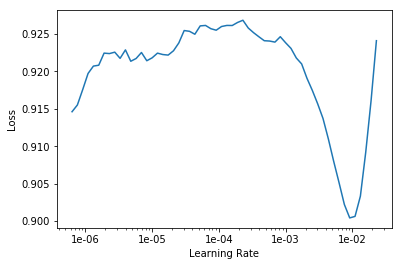

In [26]:
learn.lr_find()
learn.recorder.plot(stop_div=False)

In [27]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.298532,0.083639,00:38
1,0.391199,0.204823,00:37
2,0.417922,0.235487,00:39
3,0.394340,0.204987,00:37
4,0.365897,0.164380,00:39
5,0.331697,0.122845,00:37
6,0.301059,0.082494,00:39
7,0.272459,0.048644,00:38
8,0.255077,0.027331,00:38
9,0.250805,0.020773,00:37


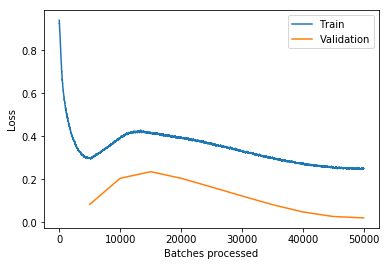

In [28]:
learn.recorder.plot_losses(True)

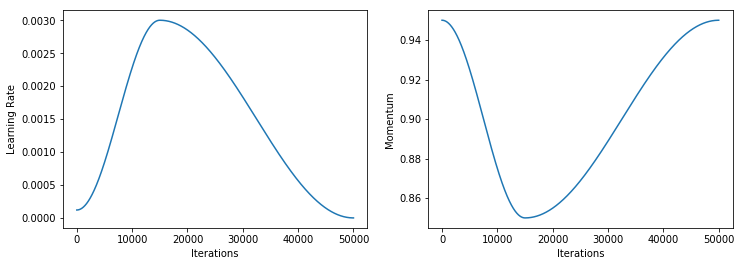

In [29]:
learn.recorder.plot_lr(True)

In [30]:
m = learn.model.eval()
m

Autoencoder(
  (noise): BatchSwapNoise()
  (encoder): Sequential(
    (0): Linear(in_features=200, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=300, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=300, out_features=300, bias=True)
    (1): Linear(in_features=300, out_features=200, bias=True)
  )
)

In [31]:
#x,y = data.train_ds[0]
# have to convert into batch before putting into the model
#xb,_ = data.one_item(x)
#xb = xb.cuda()

In [32]:
def hooked_backward(xb, cat=y):
    with hook_output(m.encoder[0]) as hook_a: 
        with hook_output(m.encoder[1]) as hook_b: 
            with hook_output(m.encoder[2]) as hook_c: 
                with hook_output(m.decoder[0]) as hook_d: 
                    with hook_output(m.decoder[1]) as hook_e: 
                        preds = m(xb)
    return hook_a, hook_b, hook_c, hook_d, hook_e

In [33]:
#hook_a, hook_b, hook_c, hook_d, hook_e = hooked_backward(xb)
#acts_a = hook_a.stored[0].cpu()
#acts_b = hook_b.stored[0].cpu()
#acts_c = hook_c.stored[0].cpu()
#acts_d = hook_d.stored[0].cpu()
#acts_e = hook_e.stored[0].cpu()

#a = np.concatenate((acts_a, acts_b, acts_c, acts_d, acts_e))
#b = np.concatenate((acts_a, acts_b, acts_c, acts_d, acts_e))
#result_array = np.empty((0, 1400))

#np.vstack((result_array, a)).shape

In [34]:
data = None
gc.collect()

13256

In [35]:
x_il = ArraysItemList(X)
x_ils = x_il.split_none()
lls = x_ils.label_from_lists(x_ils.train, [])
data = x_ils.databunch(bs=32)

In [36]:
def extract_features(data, learner):
    len_data = len(data.train_ds)
    result = np.empty((len_data, 1400))
    for i in tqdm(range(len_data)):
        x,y = data.train_ds[i]
        xb,_ = data.one_item(x)
        xb = xb.cuda()
        hook_a, hook_b, hook_c, hook_d, hook_e = hooked_backward(xb)
        
        acts_a = hook_a.stored[0].cpu()
        acts_b = hook_b.stored[0].cpu()
        acts_c = hook_c.stored[0].cpu()
        acts_d = hook_d.stored[0].cpu()
        acts_e = hook_e.stored[0].cpu()
        result[i] = np.concatenate((acts_a, acts_b, acts_c, acts_d, acts_e))
        
    return result

In [37]:
result = extract_features(data, learn)

In [38]:
data = None 
gc.collect()

0

In [39]:
result.shape

(200000, 1400)

In [40]:
a = pd.DataFrame(result)

In [41]:
save.shape

(200000, 3)

In [42]:
a.shape

(200000, 1400)

In [43]:
save.head()

,ID_code,target,var_0
0,test_33627,NaN,0.088067
1,test_105907,NaN,0.997901
2,train_64423,0.0,0.355666
3,train_12170,1.0,0.537998
4,test_172364,NaN,-0.243130


In [44]:
a.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,0.611771,0.989309,0.005772,0.936229,-0.005602,-0.010409,1.018397,0.874551,0.274236,-0.010493,-2.205494,0.003381,-0.004227,0.006033,-0.048794,0.010245,0.512859,-0.331461,0.012567,0.163217,-0.683872,0.520593,0.641657,1.488310,0.818868,0.000882,-0.264212,1.355505,1.186742,0.448988,-0.781601,-0.528373,-0.792391,0.011586,-0.006413,-0.008857,0.375827,0.002145,0.612769,-1.660157,...,-0.060345,0.339996,0.336347,0.543422,0.666476,-0.395552,0.243747,-0.744141,-1.317157,1.009438,-1.342991,-0.345983,-1.929706,-0.238080,0.187536,-0.695962,-0.127206,-1.228456,-0.840515,-0.259855,0.160713,0.012264,0.833566,-0.555964,-0.346267,-0.716229,-0.064936,0.069095,-0.751105,-0.004461,-1.040547,0.388323,1.919207,0.536369,-0.531990,0.928213,-0.247108,1.099462,-2.132442,0.214729
1,0.686706,0.503896,0.000824,-0.893227,0.007115,0.007814,-0.853501,0.146625,0.417799,0.009829,-0.660442,-0.005103,0.011965,-0.011321,1.753128,0.002488,-0.342708,-1.640486,0.009556,-0.857910,-1.031203,0.129698,-0.244280,-0.602840,1.078794,0.004920,-0.372038,0.249779,1.584383,-0.408595,0.116576,0.288231,-0.101023,-0.021850,0.001210,-0.018499,-0.373600,0.001073,-0.624999,0.215665,...,0.886484,-0.192314,-0.862081,1.433613,0.822735,0.472856,-2.073873,-0.287304,0.201049,1.935609,-0.224103,0.850657,0.333635,-0.001243,0.744951,-0.055732,-0.884991,0.211516,0.718891,-1.241376,2.136557,0.498665,0.631328,-0.990164,-0.717666,-0.636372,0.306140,1.394505,-0.038465,0.928762,-0.150126,-0.692853,0.074308,1.545973,-0.037081,0.486468,-0.018618,-1.060832,0.342871,0.386536
2,-0.400707,0.854735,0.001759,-0.151051,0.013562,-0.009152,-0.893467,-0.588721,-0.328895,-0.001740,-0.003868,-0.002954,-0.002618,0.002718,0.807878,-0.009318,-0.508519,-0.753451,-0.001254,-0.591091,0.595953,1.206433,1.122208,-0.910662,-1.138147,-0.002833,-0.961422,1.335446,0.248254,0.998706,0.951416,0.359285,-0.995535,-0.000059,0.004636,-0.002192,1.231470,0.012557,-0.050145,-0.582990,...,-0.377324,-0.149676,-0.053031,-0.567988,0.184082,1.370263,0.224061,0.571719,0.385478,0.077598,0.658328,0.400207,-0.655321,-0.001647,0.618564,0.972938,0.309463,-0.064677,-0.250276,-0.029697,-0.388632,1.241880,-2.127642,1.968351,0.010435,-0.711485,0.463851,-0.470811,-0.348114,-0.520842,1.286050,0.611899,-0.689854,1.564230,0.460808,0.131373,-0.100625,-0.225233,0.019350,-0.685095
3,-0.216774,-0.363740,-0.003662,0.806039,-0.013107,0.003475,0.595967,0.331633,-0.689053,0.019798,0.005980,0.010970,0.034336,-0.011988,-0.526444,-0.007115,-0.062183,1.146545,0.007517,-0.344817,0.613542,-1.842710,-0.271964,-1.179799,-0.034553,0.005717,-1.572489,0.375724,-0.977161,0.992598,-0.179281,0.617084,0.977461,-0.012801,-0.004378,-0.013772,0.646521,-0.003599,-1.709185,1.224438,...,-0.420448,-0.448209,0.321179,-0.306054,0.251152,0.260292,0.384082,0.231709,0.705870,-1.124687,1.216041,0.598913,0.802091,-0.166749,-0.481492,0.479717,0.122838,-0.654206,1.008723,-1.037088,-0.704198,0.896969,0.594762,0.432098,-0.411901,-1.121424,1.069517,0.822494,1.404150,0.789968,1.134117,0.316694,1.065053,-0.529843,0.619577,-0.909738,-0.924659,-1.468854,-0.271570,-0.174741
4,0.305853,0.654477,-0.001598,-0.891315,-0.002766,-0.012020,0.261032,-0.195647,0.735187,0.007225,0.804496,0.008862,-0.002583,-0.007589,0.122529,0.009759,-0.419615,-0.786175,-0.008712,-0.226788,1.313091,0.443065,1.292968,0.790745,-1.161547,-0.017267,-0.283308,-1.457149,1.112044,1.300314,-1.470942,-0.214158,0.006160,0.004919,0.001323,0.010650,0.937694,0.005488,-0.696286,0.222542,...,-0.047746,0.244999,0.308571,0.585295,-0.400786,-0.366862,-0.765004,0.534011,1.127464,-0.439954,0.588143,-0.411333,0.850530,-0.015597,0.322933,-1.090017,-0.095477,-0.565737,0.408026,-0.140595,0.239080,-0.572433,-0.116458,-0.134233,0.155969,0.

In [45]:
a = pd.concat([save.iloc[:, :2], a], axis=1)

In [46]:
a.head()

,ID_code,target,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,1360,1361,1362,1363,1364,1365,1366,1367,1368,1369,1370,1371,1372,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382,1383,1384,1385,1386,1387,1388,1389,1390,1391,1392,1393,1394,1395,1396,1397,1398,1399
0,test_33627,NaN,0.611771,0.989309,0.005772,0.936229,-0.005602,-0.010409,1.018397,0.874551,0.274236,-0.010493,-2.205494,0.003381,-0.004227,0.006033,-0.048794,0.010245,0.512859,-0.331461,0.012567,0.163217,-0.683872,0.520593,0.641657,1.488310,0.818868,0.000882,-0.264212,1.355505,1.186742,0.448988,-0.781601,-0.528373,-0.792391,0.011586,-0.006413,-0.008857,0.375827,0.002145,...,-0.060345,0.339996,0.336347,0.543422,0.666476,-0.395552,0.243747,-0.744141,-1.317157,1.009438,-1.342991,-0.345983,-1.929706,-0.238080,0.187536,-0.695962,-0.127206,-1.228456,-0.840515,-0.259855,0.160713,0.012264,0.833566,-0.555964,-0.346267,-0.716229,-0.064936,0.069095,-0.751105,-0.004461,-1.040547,0.388323,1.919207,0.536369,-0.531990,0.928213,-0.247108,1.099462,-2.132442,0.214729
1,test_105907,NaN,0.686706,0.503896,0.000824,-0.893227,0.007115,0.007814,-0.853501,0.146625,0.417799,0.009829,-0.660442,-0.005103,0.011965,-0.011321,1.753128,0.002488,-0.342708,-1.640486,0.009556,-0.857910,-1.031203,0.129698,-0.244280,-0.602840,1.078794,0.004920,-0.372038,0.249779,1.584383,-0.408595,0.116576,0.288231,-0.101023,-0.021850,0.001210,-0.018499,-0.373600,0.001073,...,0.886484,-0.192314,-0.862081,1.433613,0.822735,0.472856,-2.073873,-0.287304,0.201049,1.935609,-0.224103,0.850657,0.333635,-0.001243,0.744951,-0.055732,-0.884991,0.211516,0.718891,-1.241376,2.136557,0.498665,0.631328,-0.990164,-0.717666,-0.636372,0.306140,1.394505,-0.038465,0.928762,-0.150126,-0.692853,0.074308,1.545973,-0.037081,0.486468,-0.018618,-1.060832,0.342871,0.386536
2,train_64423,0.0,-0.400707,0.854735,0.001759,-0.151051,0.013562,-0.009152,-0.893467,-0.588721,-0.328895,-0.001740,-0.003868,-0.002954,-0.002618,0.002718,0.807878,-0.009318,-0.508519,-0.753451,-0.001254,-0.591091,0.595953,1.206433,1.122208,-0.910662,-1.138147,-0.002833,-0.961422,1.335446,0.248254,0.998706,0.951416,0.359285,-0.995535,-0.000059,0.004636,-0.002192,1.231470,0.012557,...,-0.377324,-0.149676,-0.053031,-0.567988,0.184082,1.370263,0.224061,0.571719,0.385478,0.077598,0.658328,0.400207,-0.655321,-0.001647,0.618564,0.972938,0.309463,-0.064677,-0.250276,-0.029697,-0.388632,1.241880,-2.127642,1.968351,0.010435,-0.711485,0.463851,-0.470811,-0.348114,-0.520842,1.286050,0.611899,-0.689854,1.564230,0.460808,0.131373,-0.100625,-0.225233,0.019350,-0.685095
3,train_12170,1.0,-0.216774,-0.363740,-0.003662,0.806039,-0.013107,0.003475,0.595967,0.331633,-0.689053,0.019798,0.005980,0.010970,0.034336,-0.011988,-0.526444,-0.007115,-0.062183,1.146545,0.007517,-0.344817,0.613542,-1.842710,-0.271964,-1.179799,-0.034553,0.005717,-1.572489,0.375724,-0.977161,0.992598,-0.179281,0.617084,0.977461,-0.012801,-0.004378,-0.013772,0.646521,-0.003599,...,-0.420448,-0.448209,0.321179,-0.306054,0.251152,0.260292,0.384082,0.231709,0.705870,-1.124687,1.216041,0.598913,0.802091,-0.166749,-0.481492,0.479717,0.122838,-0.654206,1.008723,-1.037088,-0.704198,0.896969,0.594762,0.432098,-0.411901,-1.121424,1.069517,0.822494,1.404150,0.789968,1.134117,0.316694,1.065053,-0.529843,0.619577,-0.909738,-0.924659,-1.468854,-0.271570,-0.174741
4,test_172364,NaN,0.305853,0.654477,-0.001598,-0.891315,-0.002766,-0.012020,0.261032,-0.195647,0.735187,0.007225,0.804496,0.008862,-0.002583,-0.007589,0.122529,0.009759,-0.419615,-0.786175,-0.008712,-0.226788,1.313091,0.443065,1.292968,0.790745,-1.161547,-0.017267,-0.283308,-1.457149,1.112044,1.300314,-1.470942,-0.214158,0.006160,0.004919,0.001323,0.010650,0.937694,0.005488,...,-0.047746,0.244999,0.308571,0.585295,-0.400786,-0.366862,-0.765004,0.534011,1.127464,-0.439954,0.588143,-0.411333,0.850530,-0.015597,0.322933,-1.090017,-0.095477,-0.565737,0.408026,-0.140595,0.239080,-0.572433,-0.116458,-0.134233,0.155969,0.372249,0

In [47]:
import joblib
joblib.dump(a, open('result.p', 'wb'))

/opt/conda/lib/python3.6/site-packages/joblib/_multiprocessing_helpers.py:38: UserWarning: [Errno 12] Cannot allocate memory.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))
